# Analysis

Take the best mock build in `main.ipynb` and run some analysis on it.

## Imports etc

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import clustering as c

%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [5]:
sim_data = np.load("mocks/new.npy")
sim_size = 1000

# sim_data = sim_data[np.log10(sim_data["stellar_mass"]) > 11]

sats = sim_data[sim_data["upid"] != -1]
cens = sim_data[sim_data["upid"] == -1]
assert len(sim_data) == len(sats) + len(cens)

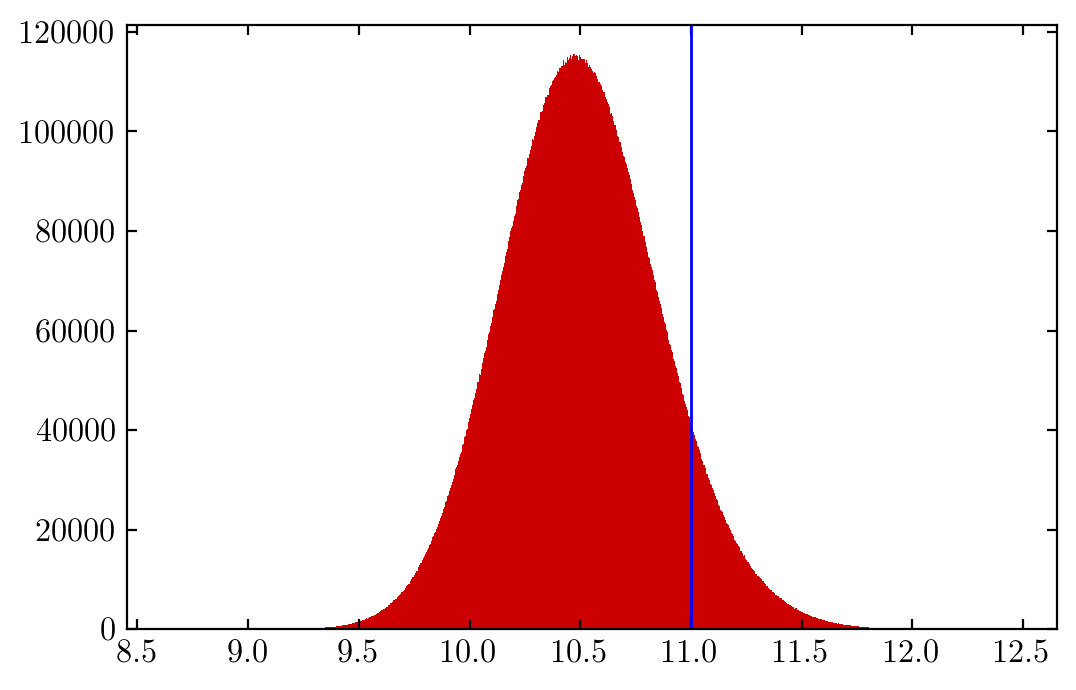

In [6]:
_, ax = plt.subplots()
ax.hist(np.log10(cens["stellar_mass"]), bins="fd")
complete_cut = 1e11
ax.axvline(np.log10(complete_cut), color="blue")

cens_complete = cens[cens["stellar_mass"] > complete_cut]
sats_complete = sats[sats["stellar_mass"] > complete_cut]
sim_data_complete = sim_data[sim_data["stellar_mass"] > complete_cut]

# Magnitude Gap

In [55]:
sats = np.sort(sats, order=["upid", "stellar_mass"])
cens = np.sort(cens, order="id")

In [56]:
idx = np.searchsorted(sats["upid"], cens["id"], side="right") - 1

In [57]:
actual_match = (sats[idx]["upid"] == cens["id"]) # Ignore cases where there are no satellites. Common as we have a high mass cut

idx = idx[actual_match]
cens_with_sats = cens[actual_match]
assert np.all(cens_with_sats["id"] == sats[idx]["upid"])

In [60]:
i = 151
print(cens_with_sats[i])
print(sats[idx[i]])

w = np.argmin(mag_gap)

print(cens_with_sats[w])
print(sats[idx[w]])

(1833552566, -1, -1, 6.02036299e+13, 567.36, 43.97127, 38.53922, 913.08893, 173.39, -1.02, -74.41, 4.12540498e+11)
(1833552561, 1833552566, 1833552566, 2.3457282e+12, 247.34, 44.12108, 38.25917, 913.29144, -415.91, -170.57, -310.75, 2.67457491e+11)
(1899982093, -1, -1, 2.23520732e+14, 993.47, 481.5986, 205.95721, 694.01306, 119.94, -633.19, -695.27, 2.06363973e+11)
(1899982148, 1899982093, 1899982093, 8.3765678e+13, 710.51, 481.95584, 205.98206, 694.09998, -1465.09, -716.51, -317.28, 1.16888695e+12)


(array([1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 5.000e+00, 2.300e+01, 9.200e+01, 3.380e+02, 1.712e+03, 4.570e+03, 6.349e+03, 6.122e+03, 5.826e+03, 5.567e+03, 4.946e+03, 4.278e+03, 3.485e+03, 2.774e+03, 2.083e+03, 1.571e+03, 9.710e+02, 6.010e+02, 3.530e+02, 1.970e+02, 1.010e+02, 4.900e+01, 2.300e+01, 8.000e+00, 2.000e+00, 4.000e+00]),
 array([-0.26827112, -0.22884602, -0.18942091, -0.14999581, -0.11057071, -0.07114561, -0.03172051,  0.00770459,  0.0471297 ,  0.0865548 ,  0.1259799 ,  0.165405  ,  0.2048301 ,  0.24425521,  0.28368031,  0.32310541,  0.36253051,  0.40195561,  0.44138071,  0.48080582,  0.52023092,  0.55965602,  0.59908112,  0.63850622,  0.67793133,  0.71735643,  0.75678153,  0.79620663,  0.83563173,  0.87505684,  0.91448194]),
 <a list of 30 Patch objects>)

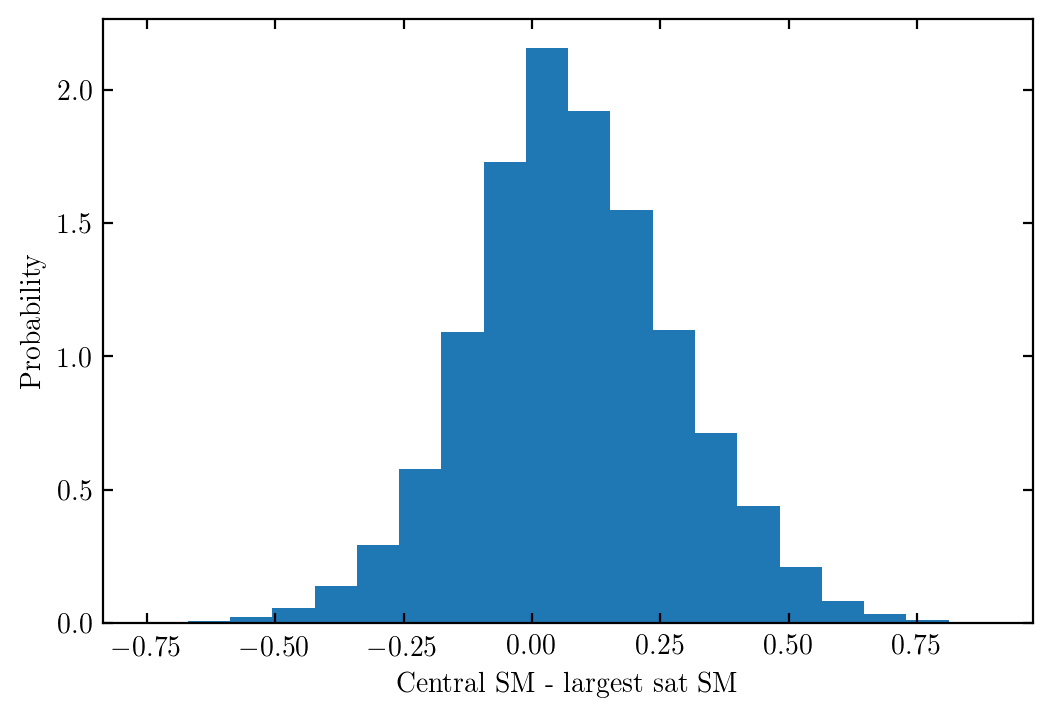

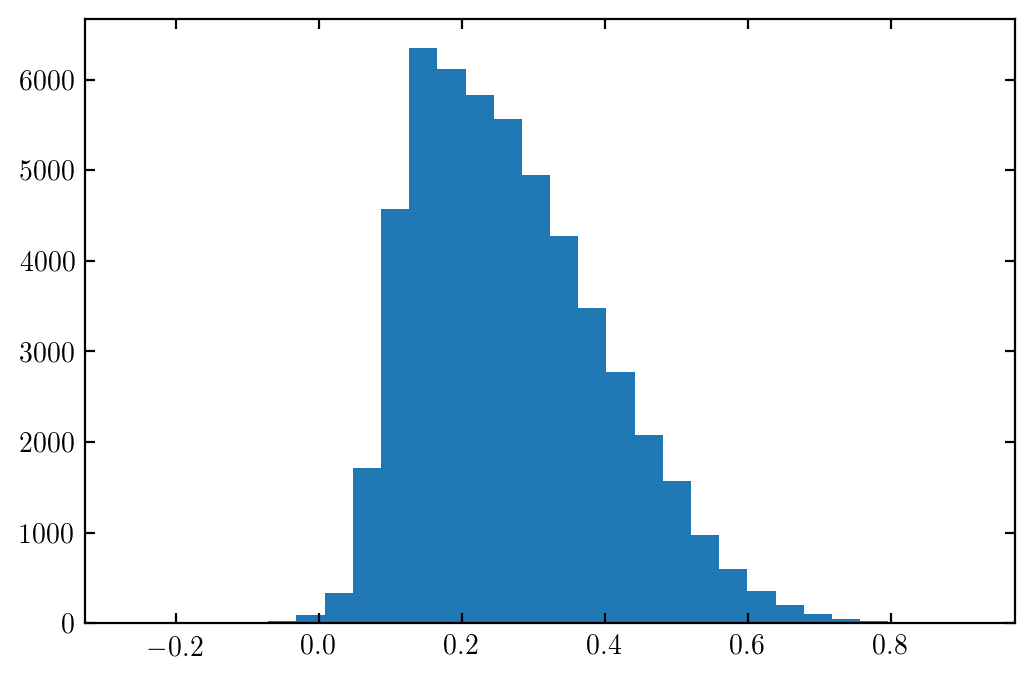

In [59]:
_, ax = plt.subplots()
mag_gap = np.log10(cens_with_sats["stellar_mass"]) - np.log10(sats[idx]["stellar_mass"])
ax.hist(mag_gap, bins=20, density=True)
ax.set(ylabel="Probability", xlabel="Central SM - largest sat SM")

_, ax = plt.subplots()
vmax_gap = np.log10(cens_with_sats["Vmax@Mpeak"]) - np.log10(sats[idx]["Vmax@Mpeak"])
ax.hist(vmax_gap, bins=30)

# Satellite Fraction

## True (Rockstar) Sat Frac Mock

In [7]:
bins = np.append(
    np.linspace(11.5, 11.9, num=9),
    np.linspace(12, 12.2, num=4),
)
bin_centers = bins[:-1] + np.diff(bins)/2

[Text(0, 0.5, 'Fraction'),
 Text(0.5, 0, 'Stellar Mass'),
 Text(0.5, 1.0, 'True (Spherical) Satellite Fraction')]

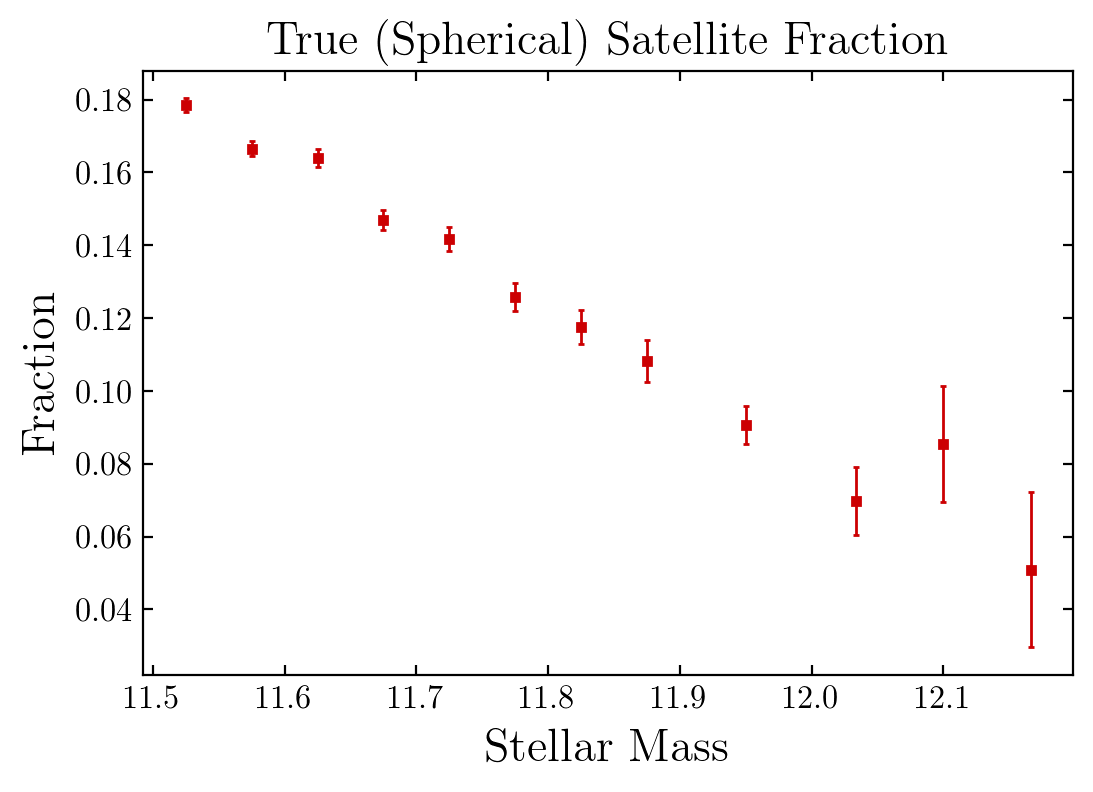

In [8]:
sats_counts, _, _ = scipy.stats.binned_statistic(sats["stellar_mass"], None, statistic="count", bins=10**bins)
cens_counts, _, _ = scipy.stats.binned_statistic(cens["stellar_mass"], None, statistic="count", bins=10**bins)

ratio = sats_counts / (cens_counts + sats_counts)
unc = ratio * np.sqrt( 1/sats_counts + 1/(sats_counts + cens_counts) )

_, ax = plt.subplots()
ax.errorbar(bin_centers, ratio, yerr=unc, ls="None", marker="s")
ax.set(title="True (Spherical) Satellite Fraction", ylabel="Fraction", xlabel="Stellar Mass")

## Cylinder Sat Frac Mock

[Text(0, 0.5, 'Fraction'),
 Text(0.5, 0, 'Stellar Mass'),
 Text(0.5, 1.0, 'Cylindrical Sat Fraction')]

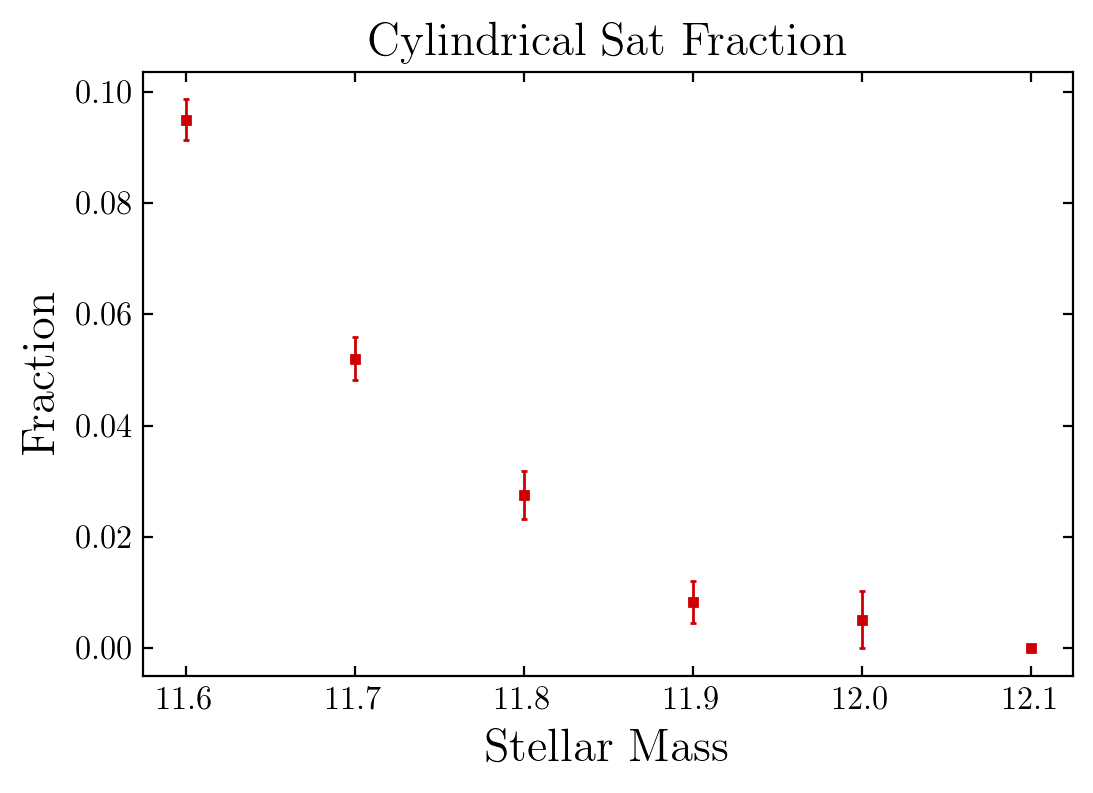

In [19]:
cen_sat_div = np.linspace(11.6, 12.1, num=6)
sat_fraction, sat_fraction_err = np.zeros_like(cen_sat_div), np.zeros_like(cen_sat_div)

for i, div in enumerate(cen_sat_div):
    pairs, all_candidate_gals = c.analysis_sim_clustering(sim_data_complete, div, sim_size)
    num_sats, num_candidates = len(set(pairs["i2"])), len(all_candidate_gals)
    
    sat_fraction[i] =  num_sats / num_candidates
    if sat_fraction[i] == 0:
        sat_fraction_err[i] = 0
    else:
        sat_fraction_err[i] = sat_fraction[i] * np.sqrt( 
            1/num_sats + 1/num_candidates
        )
    
        
_, ax = plt.subplots()
ax.errorbar(cen_sat_div, sat_fraction, yerr=sat_fraction_err, ls="None", marker="s")
ax.set(title="Cylindrical Sat Fraction", ylabel="Fraction", xlabel="Stellar Mass")

## True (Rockstar) Sat Frac Song

## Alltogether now

[Text(0, 0.5, 'Satellite fraction'), Text(0.5, 0, 'Stellar Mass')]

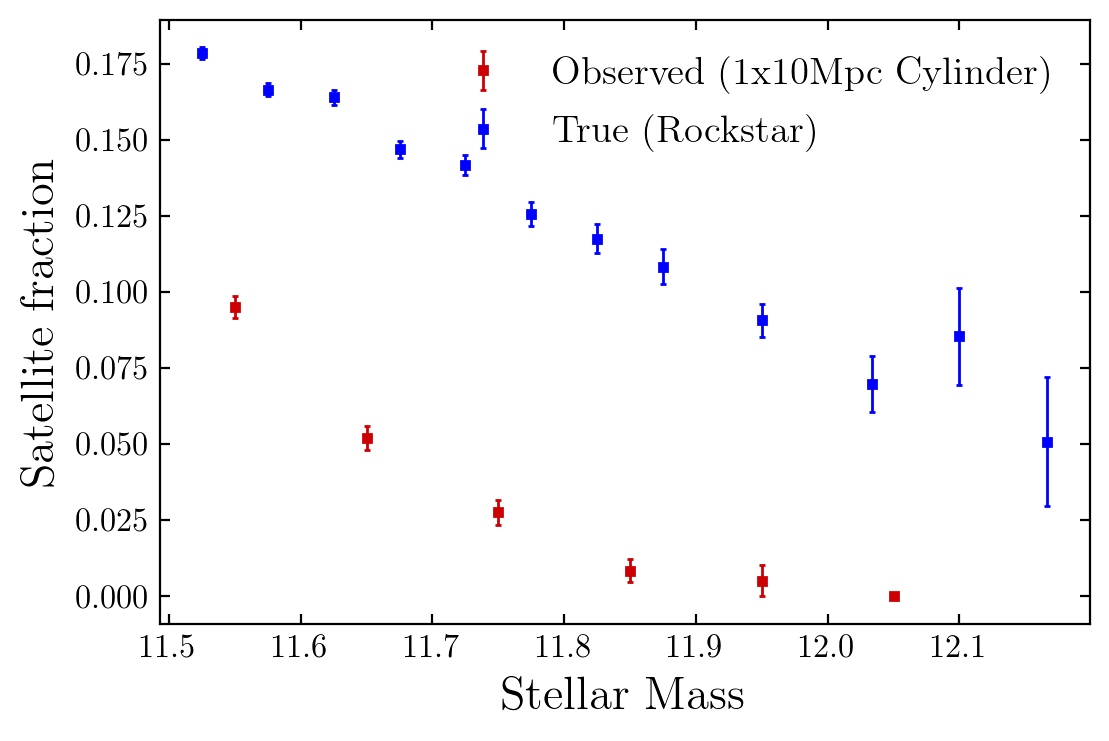

In [21]:
_, ax = plt.subplots()
ax.errorbar(sat_mass, sat_fraction, yerr=sat_fraction_err, ls="None", marker="s", label="Observed (1x10Mpc Cylinder)")
ax.errorbar(bin_centers, ratio, yerr=unc, ls="None", marker="s", label="True (Rockstar)")
ax.legend()
ax.set(ylabel="Satellite fraction", xlabel="Stellar Mass")

# Scatter SMHM in Mock

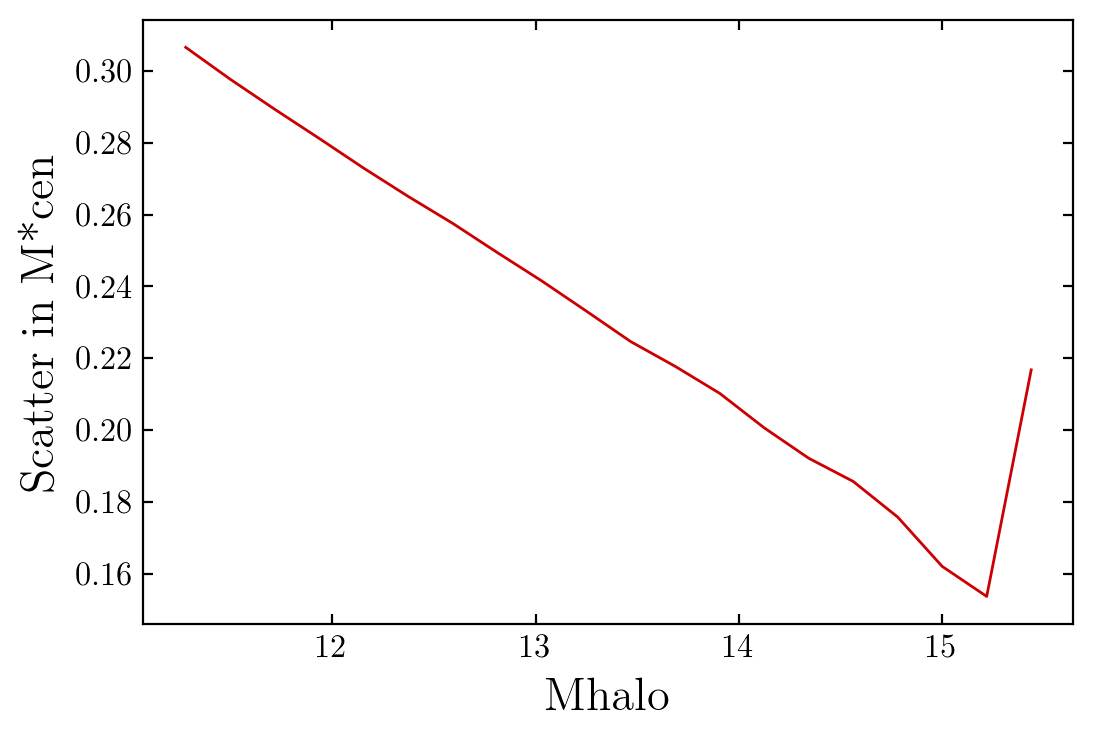

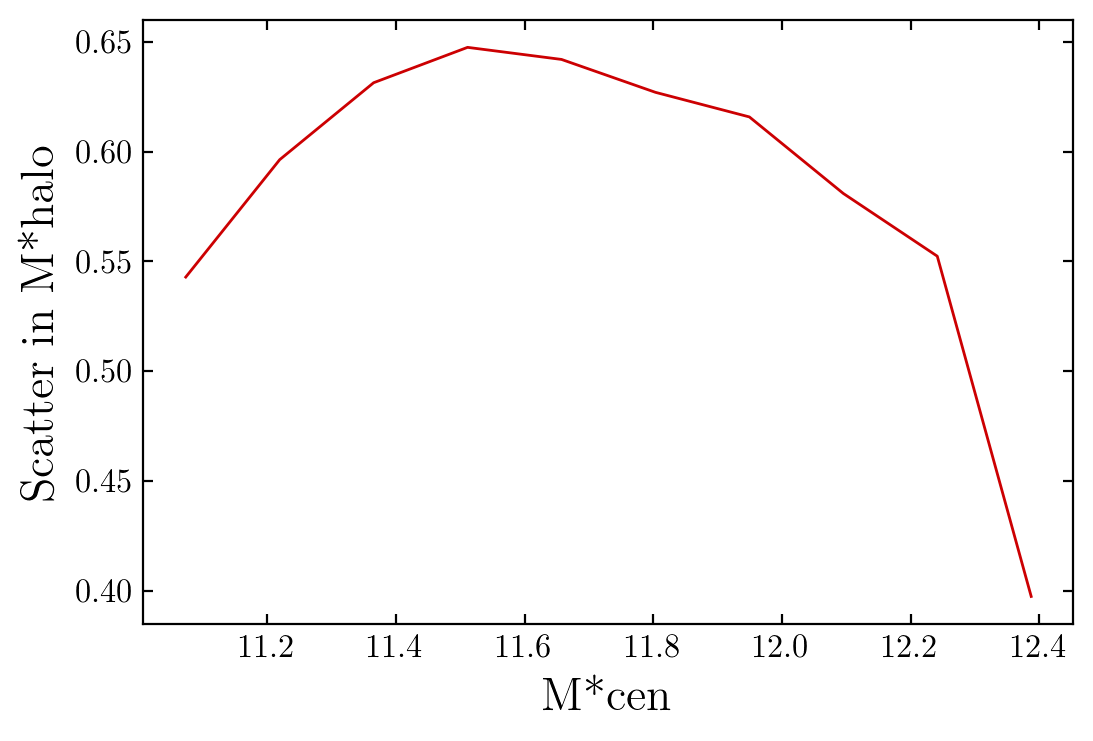

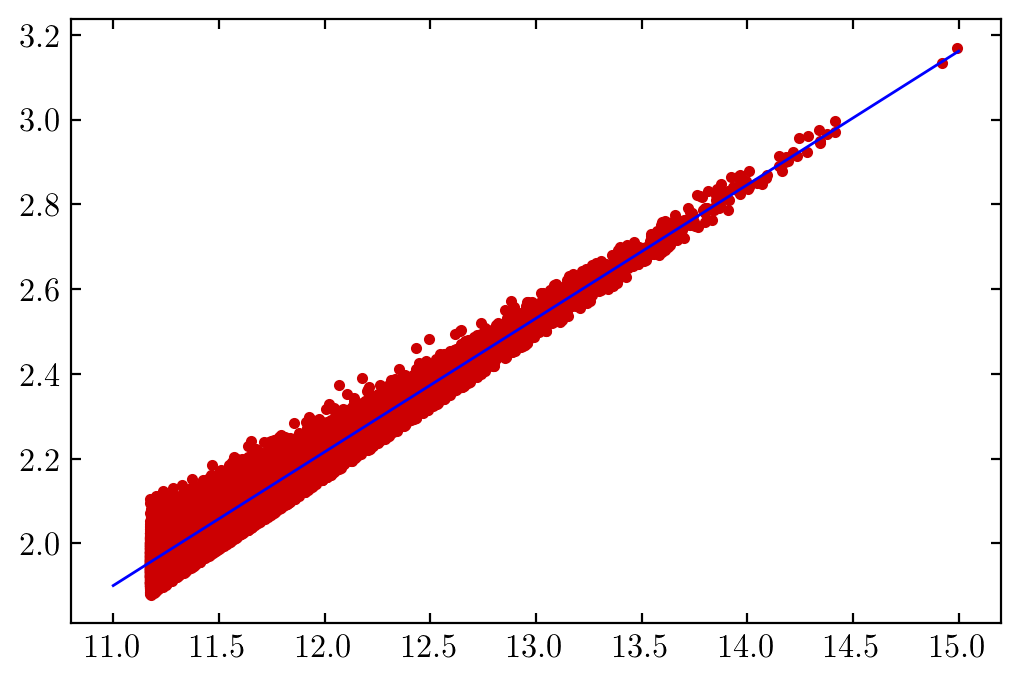

In [37]:
scatter, bin_edges, _ = scipy.stats.binned_statistic(
    np.log10(cens["Mpeak"]), 
    np.log10(cens["stellar_mass"]), 
    np.std,
    bins=20,
)
bin_centers = bin_edges[1:] - np.diff(bin_edges)/2

_, ax = plt.subplots()
ax.plot(bin_centers, scatter)
ax.set(ylabel="Scatter in M*cen", xlabel="Mhalo")

# Exactly the same, just the other way around
scatter, bin_edges, _ = scipy.stats.binned_statistic(
    np.log10(cens_complete["stellar_mass"]), 
    np.log10(cens_complete["Mpeak"]), 
    np.std,
    bins=10,
)
bin_centers = bin_edges[1:] - np.diff(bin_edges)/2

_, ax = plt.subplots()
ax.plot(bin_centers, scatter)
ax.set(ylabel="Scatter in M*halo", xlabel="M*cen")

# And explaining why scatter in M*cen at fixed Mhalo is linear -
# Mhalo is linear with Vmax which is what we conditioned on
_, ax = plt.subplots()
ax.scatter(
    np.log10(cens["Mpeak"][::1000]),
    np.log10(cens["Vmax@Mpeak"][::1000]),
)
regress = scipy.stats.linregress(np.log10(cens["Mpeak"]), np.log10(cens["Vmax@Mpeak"]))
mhalo = np.array([11, 15])
ax.plot(mhalo, regress.slope * mhalo + regress.intercept, color="blue")